# Hybrid Topic Discovery and Classification

This notebook implements a hybrid approach that combines similarity-based classification with clustering-based topic discovery.

**Workflow:**
1. Load existing topic-questions.csv (Elder Edwards' curated topics) and new student questions
2. **Similarity Filtering**: For each new question, find best match using cosine similarity
   - If similarity ≥ threshold: Save to File 1 and remove from processing
   - If similarity < threshold: Keep for clustering
3. **Topic Discovery**: Run clustering pipeline on remaining questions
   - Generate embeddings → Reduce dimensions → Cluster → Generate topics
4. **Output Generation**: Generate two files for Elder Edwards' review

**Key Features:**
- Configurable similarity threshold and processing modes
- Advanced caching system for embeddings
- GPT-5 nano/mini integration for topic naming
- Comprehensive error handling and progress tracking
- Production-ready logging and monitoring

---

## Install Dependencies

In [ ]:
!pip install openai pandas numpy scipy scikit-learn matplotlib seaborn tqdm umap-learn hdbscan bertopic backoff

## Configuration & Environment Setup

In [ ]:
# ====================================================================
# CONFIGURATION SETTINGS
# ====================================================================

# Processing mode settings
EVAL_MODE = "sample"  # Options: "sample" or "all"
SAMPLE_SIZE = 2000     # Number of questions to evaluate in sample mode

# Similarity filtering settings
SIMILARITY_THRESHOLD = 0.70  # Minimum similarity to match existing topics
REPRESENTATIVE_QUESTION_METHOD = "centroid"  # Options: "centroid" or "frequent"

# OpenAI and GPT settings
EMBEDDING_MODEL = "text-embedding-3-small"
EMBEDDING_DIMENSIONS = 1536  # Default for text-embedding-3-small
GPT_MODEL = "gpt-5-nano"  # Options: "gpt-5-nano" or "gpt-5-mini"

# Caching settings
CACHE_EMBEDDINGS = True
CACHE_DIR = "/content/drive/MyDrive/embeddings_cache"  # Google Drive cache location

# Clustering settings
UMAP_N_COMPONENTS = 5
HDBSCAN_MIN_CLUSTER_SIZE = 3  # Tighter clusters (was 15)
RANDOM_SEED = 42

# Logging configuration
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print(f"📋 CONFIGURATION:")
print(f"   Processing mode: {EVAL_MODE.upper()}")
print(f"   Sample size: {SAMPLE_SIZE if EVAL_MODE == 'sample' else 'ALL'}")
print(f"   Similarity threshold: {SIMILARITY_THRESHOLD}")
print(f"   Representative question method: {REPRESENTATIVE_QUESTION_METHOD}")
print(f"   Embedding model: {EMBEDDING_MODEL}")
print(f"   GPT model: {GPT_MODEL}")
print(f"   Caching: {'ENABLED' if CACHE_EMBEDDINGS else 'DISABLED'}")
print(f"   Random seed: {RANDOM_SEED}")
print("="*60)

📋 CONFIGURATION:
   Processing mode: SAMPLE
   Sample size: 2000
   Similarity threshold: 0.7
   Representative question method: centroid
   Embedding model: text-embedding-3-small
   GPT model: gpt-5-nano
   Caching: ENABLED
   Random seed: 42


In [ ]:
# ====================================================================
# ENVIRONMENT SETUP - Google Colab Style
# ====================================================================

import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
import json
import pickle
from pathlib import Path
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional, Any
import asyncio
import backoff
import difflib

# Environment detection and API key setup
try:
    # Check if running in Google Colab
    import google.colab
    # Production setup for Google Colab
    from google.colab import userdata
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
    print("🔧 Running in Google Colab - using userdata for API key")
except ImportError:
    # Running locally - use hardcoded key for development/testing
    OPENAI_API_KEY = "your-openai-api-key-here"  # HARDCODED FOR DEVELOPMENT
    print("🔧 Running locally - using hardcoded API key for development")
    print("⚠️  Remember to set your actual API key before running")

# Initialize OpenAI clients
try:
    from openai import OpenAI, AsyncOpenAI, APIStatusError
    client = OpenAI(api_key=OPENAI_API_KEY)
    async_client = AsyncOpenAI(api_key=OPENAI_API_KEY)
    print("✅ OpenAI clients initialized successfully")
except Exception as e:
    print(f"❌ Error initializing OpenAI clients: {e}")
    if "your-openai-api-key-here" in str(OPENAI_API_KEY):
        print("💡 Please set your actual OPENAI_API_KEY")
    else:
        print("💡 Check your API key and network connection")

🔧 Running in Google Colab - using userdata for API key
✅ OpenAI clients initialized successfully


## Question Cleaning and Preprocessing

In [ ]:
# ====================================================================
# QUESTION PREPROCESSING UTILITIES
# ====================================================================

def clean_question(question: str) -> str:
    """
    Remove ACM question prefix from questions before processing.

    This function removes prefixes like "(ACMs Question):" or "(ACM question):"
    that identify questions from ACM missionaries. These prefixes should be removed
    before embedding generation to prevent clustering based on source rather than content.

    Args:
        question (str): The original question text

    Returns:
        str: The cleaned question text with ACM prefix removed
    """
    if not isinstance(question, str):
        return str(question) if question is not None else ""

    # Define patterns to match ACM prefixes (case-insensitive)
    import re

    # Patterns to match:
    # - (ACMs Question):
    # - (ACM question):
    # - (ACMs Question)
    # - (ACM question)
    # Add colon as optional to handle both formats
    pattern = r'^\s*\(ACMs?\s+[Qq]uestion\)\s*:?\s*'

    # Remove the prefix and strip any remaining whitespace
    cleaned = re.sub(pattern, '', question, flags=re.IGNORECASE).strip()

    # Return original question if nothing was removed and it's empty after cleaning
    return cleaned if cleaned else question

def preprocess_questions_dataframe(df: pd.DataFrame, question_column: str = 'question') -> pd.DataFrame:
    """
    Apply question cleaning to a DataFrame containing questions.

    Args:
        df (pd.DataFrame): DataFrame containing questions
        question_column (str): Name of the column containing questions

    Returns:
        pd.DataFrame: DataFrame with cleaned questions
    """
    if df is None or len(df) == 0:
        return df

    df_cleaned = df.copy()

    # Count questions with ACM prefix before cleaning
    acm_pattern = r'^\s*\(ACMs?\s+[Qq]uestion\)'
    acm_questions_count = df_cleaned[question_column].str.contains(acm_pattern, na=False, regex=True).sum()

    if acm_questions_count > 0:
        print(f"🔧 Found {acm_questions_count} questions with ACM prefix - cleaning before processing...")

        # Show examples before cleaning
        acm_examples = df_cleaned[df_cleaned[question_column].str.contains(acm_pattern, na=False, regex=True)][question_column].head(3).tolist()
        print(f"📋 Examples of ACM questions before cleaning:")
        for i, example in enumerate(acm_examples, 1):
            print(f"   {i}. \"{example}\"")

    # Apply cleaning function
    df_cleaned[question_column] = df_cleaned[question_column].apply(clean_question)

    if acm_questions_count > 0:
        # Show examples after cleaning
        acm_examples_cleaned = [clean_question(q) for q in acm_examples]
        print(f"📋 Examples after cleaning:")
        for i, (original, cleaned) in enumerate(zip(acm_examples, acm_examples_cleaned), 1):
            print(f"   {i}. \"{cleaned}\"")
        print(f"✅ Cleaned {acm_questions_count} ACM questions")
    else:
        print(f"ℹ️  No ACM prefixes found in questions")

    return df_cleaned

print("🔧 Question preprocessing utilities loaded!")

🔧 Question preprocessing utilities loaded!


## Google Drive Setup (for caching)

In [ ]:
# ====================================================================
# GOOGLE DRIVE SETUP - For caching embeddings
# ====================================================================

# Create cache directory
if CACHE_EMBEDDINGS:
    # Check if running in Google Colab
    try:
        import google.colab
        # Running in Google Colab - mount Google Drive and create cache directory
        print("🔧 Detected Google Colab environment")

        # Mount Google Drive
        from google.colab import drive
        drive.mount('/content/drive')

        # Create cache directory in Google Drive
        Path(CACHE_DIR).mkdir(parents=True, exist_ok=True)
        print(f"📁 Cache directory created: {CACHE_DIR}")
        print(f"✅ Google Drive caching setup complete")

    except ImportError:
        # Running locally - use local cache
        local_cache_dir = "./embeddings_cache"
        Path(local_cache_dir).mkdir(exist_ok=True)
        CACHE_DIR = local_cache_dir  # Override for local development
        print(f"📁 Local cache directory: {CACHE_DIR}")
        print(f"✅ Local caching setup complete")

    except Exception as e:
        # Fallback if Google Drive setup fails
        print(f"⚠️ Google Drive setup failed: {e}")
        print("🔄 Falling back to disabled caching")
        CACHE_EMBEDDINGS = False

else:
    print("⚠️  Caching disabled - embeddings will be recalculated each run")

🔧 Detected Google Colab environment
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Cache directory created: /content/drive/MyDrive/embeddings_cache
✅ Google Drive caching setup complete


## Data Loading

In [ ]:
# ====================================================================
# DATA LOADING
# ====================================================================

# Upload Topics-Subtopics-Questions.csv file (Elder Edwards' curated topics with subtopics)
print("📂 Upload Topics-Subtopics-Questions.csv file:")
from google.colab import files

uploaded_topics = files.upload()
topic_filename = list(uploaded_topics.keys())[0]

# Upload questions.csv file (new student questions)
print("\n📂 Upload questions.csv file:")
uploaded_questions = files.upload()
questions_filename = list(uploaded_questions.keys())[0]

def load_data():
    """Load topic-questions and student questions datasets"""

    print("📂 Loading uploaded data files...")

    # Load Topics-Subtopics-Questions.csv (Elder Edwards' curated topics with subtopics)
    try:
        topic_questions_df = pd.read_csv(topic_filename)
        print(f"✅ Loaded {len(topic_questions_df)} existing topic questions")
        print(f"   Columns: {list(topic_questions_df.columns)}")

        # Validate required columns for new format
        required_cols = ['Topics', 'Subtopics', 'Questions']
        missing_cols = [col for col in required_cols if col not in topic_questions_df.columns]
        if missing_cols:
            print(f"❌ Missing required columns in Topics-Subtopics-Questions.csv: {missing_cols}")
            return None, None

        # Rename columns to match existing code expectations
        topic_questions_df = topic_questions_df.rename(columns={
            'Topics': 'topic',
            'Subtopics': 'subtopic',
            'Questions': 'question'
        })
        print(f"✅ Renamed columns: Topics→topic, Subtopics→subtopic, Questions→question")

    except Exception as e:
        print(f"❌ Error loading topic-questions file: {e}")
        return None, None

    # Load questions.csv (new student questions)
    try:
        # Handle different possible formats of questions file
        if questions_filename.endswith('.txt'):
            # If it's a text file, read line by line
            with open(questions_filename, "r", encoding="utf-8") as f:
                questions_list = [line.strip() for line in f if line.strip()]
            questions_df = pd.DataFrame({'question': questions_list})
        else:
            # If it's a CSV file, try different parsing approaches
            print(f"📋 Parsing CSV file: {questions_filename}")

            # First, try reading as text file (line by line) since it might be questions with commas
            with open(questions_filename, "r", encoding="utf-8") as f:
                lines = f.readlines()

            # Clean up lines - remove trailing commas and whitespace
            questions_list = []
            for line in lines:
                question = line.strip().rstrip(',').strip()
                if question:  # Only add non-empty questions
                    questions_list.append(question)

            questions_df = pd.DataFrame({'question': questions_list})
            print(f"📊 Parsed {len(questions_list)} lines from CSV")

        # Final cleanup - remove any remaining empty questions
        questions_df = questions_df[questions_df['question'].notna() & (questions_df['question'] != '')]


        print(f"✅ Loaded {len(questions_df)} student questions (duplicates preserved as per requirements)")
        print("🔎 Sample:", questions_df['question'].head(5).tolist())

    except Exception as e:
        print(f"❌ Error loading questions file: {e}")
        return None, None

    return topic_questions_df, questions_df

# Load the data
topic_questions_df, questions_df = load_data()

if topic_questions_df is not None and questions_df is not None:
    # Apply question preprocessing to remove ACM prefixes
    print(f"\n🔧 PREPROCESSING QUESTIONS:")
    print(f"   Cleaning existing topic questions...")
    topic_questions_df = preprocess_questions_dataframe(topic_questions_df, 'question')

    print(f"   Cleaning new student questions...")
    questions_df = preprocess_questions_dataframe(questions_df, 'question')

    print(f"\n📊 DATA SUMMARY:")
    print(f"   Existing topic questions: {len(topic_questions_df)}")
    print(f"   New student questions: {len(questions_df)}")
    print(f"   Unique existing topics: {topic_questions_df['topic'].nunique()}")
    print(f"   Unique existing subtopics: {topic_questions_df['subtopic'].nunique()}")

    # Show sample data
    print(f"\n🔍 SAMPLE EXISTING TOPIC-SUBTOPIC QUESTIONS:")
    display(topic_questions_df.head())

    print(f"\n🔍 SAMPLE NEW STUDENT QUESTIONS:")
    display(questions_df.head(10))

📂 Upload Topics-Subtopics-Questions.csv file:


Saving Topics-Subtopics-Questions.csv to Topics-Subtopics-Questions.csv

📂 Upload questions.csv file:


Saving questions.csv to questions (2).csv
📂 Loading uploaded data files...
✅ Loaded 120 existing topic questions
   Columns: ['Topics', 'Subtopics', 'Questions']
✅ Renamed columns: Topics→topic, Subtopics→subtopic, Questions→question
📋 Parsing CSV file: questions (2).csv
📊 Parsed 5918 lines from CSV
✅ Loaded 5918 student questions (duplicates preserved as per requirements)
🔎 Sample: ['What is the PC 103 agenda print', 'What is PC 103 agenda printable', 'PC 103 agenda printable', 'what should a student do when they miss a gathering', '(ACMs Question): Is there any devotional for week 3 gathering of byupathway']

🔧 PREPROCESSING QUESTIONS:
   Cleaning existing topic questions...
ℹ️  No ACM prefixes found in questions
   Cleaning new student questions...
🔧 Found 13 questions with ACM prefix - cleaning before processing...
📋 Examples of ACM questions before cleaning:
   1. "(ACMs Question): Is there any devotional for week 3 gathering of byupathway"
   2. "(ACMs Question): What is MyGather

,topic,subtopic,question
0,Academic Calendar,Financial Holds Applied,When are financial holds applied?
1,Academic Calendar,Priority Registration Deadline,When is the Priority Registration Registration...
2,Academic Calendar,Add Course Deadline,When is the Add Course Deadline?
3,Academic Calendar,Application Deadline,When is the PathwayConnect Application Deadline?
4,Academic Calendar,Tuition Discount Deadline,When is the deadline to apply for a Tuition Di...



🔍 SAMPLE NEW STUDENT QUESTIONS:


,question
0,What is the PC 103 agenda print
1,What is PC 103 agenda printable
2,PC 103 agenda printable
3,what should a student do when they miss a gath...
4,Is there any devotional for week 3 gathering o...
5,The amount students are charged in PC101 is th...
6,How does a student enduresuccessful registrati...
7,When does term 6 open
8,A student has not completed registration showi...
9,how does a student withdraw from a course?


## Dataset Preparation

In [ ]:
# ====================================================================
# DATASET PREPARATION
# ====================================================================

def prepare_evaluation_dataset(questions_df, mode: str = EVAL_MODE, sample_size: int = SAMPLE_SIZE) -> pd.DataFrame:
    """Prepare dataset based on evaluation mode with reproducible sampling"""

    if mode == "sample":
        # Use reproducible sampling
        sample_questions = questions_df.sample(
            n=min(sample_size, len(questions_df)),
            random_state=RANDOM_SEED
        ).copy()
        print(f"📝 SAMPLE MODE: Using {len(sample_questions)} questions (random sample with seed {RANDOM_SEED})")
    elif mode == "all":
        sample_questions = questions_df.copy()
        print(f"📝 FULL MODE: Using all {len(sample_questions)} questions")
    else:
        raise ValueError(f"Invalid mode: {mode}. Use 'sample' or 'all'")

    # Estimate cost breakdown for embeddings
    topic_questions_count = len(topic_questions_df)
    eval_questions_count = len(sample_questions)

    # Calculate tokens and costs separately for clarity
    topic_tokens = topic_questions_count * 50  # Rough estimate: 50 tokens per question
    eval_tokens = eval_questions_count * 50
    total_tokens = topic_tokens + eval_tokens

    # Updated pricing for text-embedding-3-small
    embedding_cost_per_1M = 0.02  # $0.02 per 1M tokens
    topic_cost = (topic_tokens / 1000000) * embedding_cost_per_1M
    eval_cost = (eval_tokens / 1000000) * embedding_cost_per_1M
    total_embedding_cost = topic_cost + eval_cost

    # Estimate GPT cost for topic naming (only for new clusters)
    estimated_new_clusters = min(20, eval_questions_count // 10)  # Conservative estimate
    if GPT_MODEL == "gpt-5-nano":
        gpt_input_cost_per_1M = 0.050   # $0.050 per 1M input tokens
        gpt_output_cost_per_1M = 0.400  # $0.400 per 1M output tokens
    elif GPT_MODEL == "gpt-5-mini":
        gpt_input_cost_per_1M = 0.250   # $0.250 per 1M input tokens
        gpt_output_cost_per_1M = 2.000  # $2.000 per 1M output tokens
    else:  # Default case (if GPT_MODEL is neither "gpt-5-nano" nor "gpt-5-mini")
        gpt_input_cost_per_1M = 1.250   # $1.250 per 1M input tokens
        gpt_output_cost_per_1M = 10.000  # $10.000 per 1M output tokens

    gpt_input_tokens = estimated_new_clusters * 200  # Estimated tokens per topic naming request
    gpt_output_tokens = estimated_new_clusters * 50   # Estimated output tokens

    gpt_input_cost = (gpt_input_tokens / 1000000) * gpt_input_cost_per_1M
    gpt_output_cost = (gpt_output_tokens / 1000000) * gpt_output_cost_per_1M
    total_gpt_cost = gpt_input_cost + gpt_output_cost

    total_cost = total_embedding_cost + total_gpt_cost

    print(f"\n💰 COST ESTIMATE:")
    print(f"   📊 EMBEDDINGS:")
    print(f"     Topic questions: {topic_questions_count} (tokens: {topic_tokens:,}, cost: ${topic_cost:.4f})")
    print(f"     Student questions: {eval_questions_count} (tokens: {eval_tokens:,}, cost: ${eval_cost:.4f})")
    print(f"     Embedding subtotal: ${total_embedding_cost:.4f}")
    print(f"   🤖 GPT-5 TOPIC NAMING:")
    print(f"     Estimated new clusters: {estimated_new_clusters}")
    print(f"     Input tokens: {gpt_input_tokens:,} (cost: ${gpt_input_cost:.4f})")
    print(f"     Output tokens: {gpt_output_tokens:,} (cost: ${gpt_output_cost:.4f})")
    print(f"     GPT subtotal: ${total_gpt_cost:.4f}")
    print(f"   💵 TOTAL ESTIMATED COST: ${total_cost:.4f}")

    return sample_questions

# Prepare evaluation dataset
eval_questions_df = prepare_evaluation_dataset(questions_df)

print(f"\n🎯 READY FOR HYBRID PROCESSING:")
print(f"   Mode: {EVAL_MODE.upper()}")
print(f"   Student questions to process: {len(eval_questions_df)}")
print(f"   Existing topic questions: {len(topic_questions_df)}")
print(f"   Similarity threshold: {SIMILARITY_THRESHOLD}")


📝 SAMPLE MODE: Using 2000 questions (random sample with seed 42)

💰 COST ESTIMATE:
   📊 EMBEDDINGS:
     Topic questions: 120 (tokens: 6,000, cost: $0.0001)
     Student questions: 2000 (tokens: 100,000, cost: $0.0020)
     Embedding subtotal: $0.0021
   🤖 GPT-5 TOPIC NAMING:
     Estimated new clusters: 20
     Input tokens: 4,000 (cost: $0.0002)
     Output tokens: 1,000 (cost: $0.0004)
     GPT subtotal: $0.0006
   💵 TOTAL ESTIMATED COST: $0.0027

🎯 READY FOR HYBRID PROCESSING:
   Mode: SAMPLE
   Student questions to process: 2000
   Existing topic questions: 120
   Similarity threshold: 0.7


## Embedding Generation with Advanced Caching

In [ ]:
# ====================================================================
# EMBEDDING UTILITIES WITH ADVANCED CACHING
# ====================================================================

def get_cache_path(text: str, model: str) -> str:
    """Generate cache file path for a given text and model"""
    import hashlib
    text_hash = hashlib.md5(text.encode()).hexdigest()[:12]
    return os.path.join(CACHE_DIR, f"{model}_{text_hash}.pkl")

def load_cached_embedding(text: str, model: str) -> Optional[List[float]]:
    """Load embedding from cache if available"""
    if not CACHE_EMBEDDINGS:
        return None

    cache_path = get_cache_path(text, model)
    if os.path.exists(cache_path):
        try:
            with open(cache_path, 'rb') as f:
                return pickle.load(f)
        except Exception as e:
            # Silently handle cache read errors to avoid interrupting processing
            logger.debug(f"Cache read error for {cache_path}: {e}")
            pass
    return None

def save_embedding_to_cache(text: str, model: str, embedding: List[float]):
    """Save embedding to cache with automatic directory creation"""
    if not CACHE_EMBEDDINGS:
        return

    cache_path = get_cache_path(text, model)
    try:
        # Ensure cache directory exists
        cache_dir = os.path.dirname(cache_path)
        Path(cache_dir).mkdir(parents=True, exist_ok=True)

        # Save the embedding
        with open(cache_path, 'wb') as f:
            pickle.dump(embedding, f)
    except Exception as e:
        # Silently handle cache write errors to avoid interrupting processing
        # Only print error on first occurrence to avoid spam
        if not hasattr(save_embedding_to_cache, '_error_shown'):
            logger.warning(f"Cache write disabled due to error: {e}")
            logger.info("Continuing without caching...")
            save_embedding_to_cache._error_shown = True

def get_embedding(text: str, model: str = EMBEDDING_MODEL) -> List[float]:
    """Get embedding for text with caching support and question preprocessing"""

    # Clean question text (remove ACM prefixes) before processing
    cleaned_text = clean_question(text)

    # Try to load from cache first (using cleaned text for cache key)
    cached_embedding = load_cached_embedding(cleaned_text, model)
    if cached_embedding is not None:
        return cached_embedding

    # Generate new embedding
    try:
        response = client.embeddings.create(
            model=model,
            input=cleaned_text.replace("\n", " ")  # Clean text
        )
        embedding = response.data[0].embedding

        # Cache the result (will handle errors silently)
        save_embedding_to_cache(cleaned_text, model, embedding)

        return embedding
    except Exception as e:
        logger.error(f"Error generating embedding for text: {cleaned_text[:50]}...")
        logger.error(f"Error details: {e}")
        return None

def get_embeddings_batch(texts: List[str], model: str = EMBEDDING_MODEL, batch_size: int = 1000) -> List[List[float]]:
    """Get embeddings for multiple texts with true batch processing, caching, and question preprocessing"""

    # Clean all texts first (remove ACM prefixes)
    cleaned_texts = [clean_question(text) for text in texts]

    embeddings = []
    cache_hits = 0
    api_calls = 0
    batch_count = 0

    print(f"🔄 Generating embeddings for {len(cleaned_texts)} texts...")

    # Process in batches for API efficiency
    for i in tqdm(range(0, len(cleaned_texts), batch_size), desc="Processing batches"):
        batch_texts = cleaned_texts[i:i+batch_size]
        batch_embeddings = []
        uncached_texts = []
        uncached_indices = []

        # Check cache for each text in batch
        for j, text in enumerate(batch_texts):
            cached_embedding = load_cached_embedding(text, model)
            if cached_embedding is not None:
                batch_embeddings.append(cached_embedding)
                cache_hits += 1
            else:
                batch_embeddings.append(None)  # Placeholder
                uncached_texts.append(text)
                uncached_indices.append(j)

        # Generate embeddings for uncached texts
        if uncached_texts:
            try:
                response = client.embeddings.create(
                    model=model,
                    input=uncached_texts
                )

                new_embeddings = [data.embedding for data in response.data]
                api_calls += len(uncached_texts)
                batch_count += 1

                # Fill in the uncached embeddings and save to cache
                for idx, embedding in zip(uncached_indices, new_embeddings):
                    batch_embeddings[idx] = embedding
                    save_embedding_to_cache(batch_texts[idx], model, embedding)

                # Rate limiting for batch API calls
                if batch_count % 5 == 0:  # Brief pause every 5 batches
                    time.sleep(1)

            except Exception as e:
                logger.error(f"Error generating embeddings for batch: {e}")
                # Fill with zero vectors for failed embeddings
                for idx in uncached_indices:
                    batch_embeddings[idx] = [0.0] * EMBEDDING_DIMENSIONS

        embeddings.extend(batch_embeddings)

    print(f"✅ Embedding generation complete!")
    print(f"   Cache hits: {cache_hits}")
    print(f"   API calls: {api_calls}")
    print(f"   Total processed: {len(embeddings)}")
    print(f"   Cache efficiency: {cache_hits/len(embeddings)*100:.1f}%")

    return embeddings

print("🔧 Advanced embedding utilities with caching ready!")

🔧 Advanced embedding utilities with caching ready!


## Similarity-Based Classification

In [ ]:
# ====================================================================
# SIMILARITY-BASED CLASSIFICATION
# ====================================================================

def find_best_topic_match(question_embedding: List[float], topic_embeddings_df: pd.DataFrame) -> Optional[Dict]:
    """Find the best matching topic for a question embedding using cosine similarity"""

    if not question_embedding or len(question_embedding) != EMBEDDING_DIMENSIONS:
        print(f"❌ ERROR: Invalid question embedding - expected dimension {EMBEDDING_DIMENSIONS}, got {len(question_embedding) if question_embedding else 0}")
        return None

    best_distance = float('inf')
    best_match = None

    for idx, row in topic_embeddings_df.iterrows():
        topic_embedding = row['embedding']

        # Error handling for topic embeddings
        if not topic_embedding:
            print(f"❌ ERROR: No topic embedding for topic '{row['topic']}' - subtopic '{row['subtopic']}' - skipping")
            continue

        if len(topic_embedding) != EMBEDDING_DIMENSIONS:
            print(f"❌ ERROR: Invalid topic embedding dimension for topic '{row['topic']}' - subtopic '{row['subtopic']}' - expected {EMBEDDING_DIMENSIONS}, got {len(topic_embedding)} - skipping")
            continue

        try:
            # Calculate cosine distance (1 - cosine similarity)
            distance = cosine(question_embedding, topic_embedding)

            if distance < best_distance:
                best_distance = distance
                best_match = {
                    'topic': row['topic'],
                    'subtopic': row['subtopic'],  # Capture subtopic
                    'topic_question': row['question'],
                    'distance': distance,
                    'similarity': 1 - distance  # Convert distance to similarity
                }
        except Exception as e:
            print(f"❌ ERROR: Failed to calculate cosine distance for topic '{row['topic']}' - subtopic '{row['subtopic']}': {e} - skipping")
            continue

    return best_match

def classify_by_similarity(
    questions_df: pd.DataFrame,
    topic_questions_df: pd.DataFrame,
    threshold: float = SIMILARITY_THRESHOLD
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Classify questions by similarity to existing topics.

    Returns:
        similar_questions_df: Questions matching existing topics (>= threshold)
        remaining_questions_df: Questions for clustering (< threshold)
    """

    print(f"🎯 Step 1: Similarity-based classification (threshold: {threshold})")

    # Generate embeddings for existing topic questions
    print(f"📊 Generating embeddings for {len(topic_questions_df)} existing topic questions...")
    topic_questions_list = topic_questions_df['question'].tolist()
    topic_embeddings = get_embeddings_batch(topic_questions_list)

    # Add embeddings to dataframe
    topic_questions_with_embeddings = topic_questions_df.copy()
    topic_questions_with_embeddings['embedding'] = topic_embeddings

    # Generate embeddings for student questions
    print(f"📊 Generating embeddings for {len(questions_df)} student questions...")
    student_questions_list = questions_df['question'].tolist()
    student_embeddings = get_embeddings_batch(student_questions_list)

    # Classify each student question
    similar_questions = []
    remaining_questions = []

    print(f"🔍 Classifying {len(questions_df)} questions against existing topics...")

    with tqdm(total=len(questions_df), desc="Classifying") as pbar:
        for i, (question, embedding) in enumerate(zip(student_questions_list, student_embeddings)):
            if embedding and len(embedding) == EMBEDDING_DIMENSIONS:
                best_match = find_best_topic_match(embedding, topic_questions_with_embeddings)

                if best_match and best_match['similarity'] >= threshold:
                    # Question matches existing topic - capture both topic and subtopic
                    similar_questions.append({
                        'question': question,
                        'matched_topic': best_match['topic'],
                        'matched_subtopic': best_match['subtopic'],  # Capture subtopic
                        'matched_topic_question': best_match['topic_question'],
                        'similarity_score': best_match['similarity']
                    })
                else:
                    # Question doesn't match - add to clustering queue
                    remaining_questions.append({
                        'question': question,
                        'embedding': embedding
                    })
            else:
                # Handle failed embedding with error logging
                print(f"❌ ERROR: Invalid student question embedding - expected dimension {EMBEDDING_DIMENSIONS}, got {len(embedding) if embedding else 0} for question: '{question[:50]}...' - adding to clustering queue with zero vector")
                remaining_questions.append({
                    'question': question,
                    'embedding': [0.0] * EMBEDDING_DIMENSIONS
                })

            pbar.update(1)

    # Convert to DataFrames
    similar_questions_df = pd.DataFrame(similar_questions)
    remaining_questions_df = pd.DataFrame(remaining_questions)

    # Summary statistics
    total_questions = len(questions_df)
    similar_count = len(similar_questions_df)
    remaining_count = len(remaining_questions_df)

    print(f"\n✅ Similarity classification complete!")
    print(f"   📊 RESULTS SUMMARY:")
    print(f"     Total questions processed: {total_questions}")
    print(f"     Similar to existing topics (≥{threshold}): {similar_count} ({similar_count/total_questions*100:.1f}%)")
    print(f"     Remaining for clustering (<{threshold}): {remaining_count} ({remaining_count/total_questions*100:.1f}%)")

    if len(similar_questions_df) > 0:
        avg_similarity = similar_questions_df['similarity_score'].mean()
        print(f"     Average similarity score: {avg_similarity:.3f}")
        print(f"\n🔍 SAMPLE SIMILAR QUESTIONS:")
        for i, row in similar_questions_df.head(5).iterrows():
            print(f"     Q: \"{row['question'][:60]}...\"")
            print(f"        → {row['matched_topic']} | {row['matched_subtopic']} (similarity: {row['similarity_score']:.3f})")

    return similar_questions_df, remaining_questions_df

# Run similarity-based classification
similar_questions_df, remaining_questions_df = classify_by_similarity(
    eval_questions_df,
    topic_questions_df,
    SIMILARITY_THRESHOLD
)

🎯 Step 1: Similarity-based classification (threshold: 0.7)
📊 Generating embeddings for 120 existing topic questions...
🔄 Generating embeddings for 120 texts...


Processing batches: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


✅ Embedding generation complete!
   Cache hits: 120
   API calls: 0
   Total processed: 120
   Cache efficiency: 100.0%
📊 Generating embeddings for 2000 student questions...
🔄 Generating embeddings for 2000 texts...


Processing batches: 100%|██████████| 2/2 [06:00<00:00, 180.44s/it]


✅ Embedding generation complete!
   Cache hits: 1720
   API calls: 280
   Total processed: 2000
   Cache efficiency: 86.0%
🔍 Classifying 2000 questions against existing topics...


Classifying: 100%|██████████| 2000/2000 [01:18<00:00, 25.39it/s]


✅ Similarity classification complete!
   📊 RESULTS SUMMARY:
     Total questions processed: 2000
     Similar to existing topics (≥0.7): 306 (15.3%)
     Remaining for clustering (<0.7): 1694 (84.7%)
     Average similarity score: 0.779

🔍 SAMPLE SIMILAR QUESTIONS:
     Q: "when so students need their ecclesastical endorsement..."
        → Ecclesiastical Endorsements | When is Ecclesiastical Endorsement Required (similarity: 0.875)
     Q: "What courses are offered in PathwayConnect?..."
        → Courses | PathwayConnect Courses (similarity: 1.000)
     Q: "how does a student submit a ticket..."
        → Tickets | Student (similarity: 0.798)
     Q: "how does a student find their gathering zoom room link..."
        → Accessing Zoom Gathering | Finding Zoom Gathering Link (similarity: 0.715)
     Q: "How do returning PathwayConnect who need to complete Pathway..."
        → Continuing Student Registration | PathwayConnect Continuing Student (similarity: 0.833)


## Clustering-Based Topic Discovery

In [ ]:
# ====================================================================
# CLUSTERING-BASED TOPIC DISCOVERY
# ====================================================================

def perform_clustering_analysis(remaining_questions_df: pd.DataFrame) -> Optional[pd.DataFrame]:
    """
    Perform clustering analysis on questions that didn't match existing topics.

    Returns:
        clustered_questions_df: DataFrame with cluster assignments and topic info
    """

    if len(remaining_questions_df) == 0:
        print("🔍 No questions remaining for clustering - all matched existing topics!")
        return None

    print(f"\n🎯 Step 2: Clustering-based topic discovery")
    print(f"📊 Processing {len(remaining_questions_df)} questions for clustering...")

    # Extract embeddings and questions
    questions = remaining_questions_df['question'].tolist()
    embeddings = np.array(remaining_questions_df['embedding'].tolist())

    print(f"✅ Embeddings shape: {embeddings.shape}")

    # Step 1: Dimensionality reduction with UMAP
    print(f"🔄 Reducing dimensions: {embeddings.shape[1]} → {UMAP_N_COMPONENTS}")

    from umap import UMAP
    umap_model = UMAP(
        n_components=UMAP_N_COMPONENTS,
        min_dist=0.0,
        metric='cosine',
        random_state=RANDOM_SEED
    )
    reduced_embeddings = umap_model.fit_transform(embeddings)
    print(f"✅ UMAP reduction complete: {reduced_embeddings.shape}")

    # Step 2: Clustering with HDBSCAN
    print(f"🔄 Clustering with HDBSCAN (min_cluster_size: {HDBSCAN_MIN_CLUSTER_SIZE})")

    from hdbscan import HDBSCAN
    hdbscan_model = HDBSCAN(
        min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
        metric="euclidean",
        cluster_selection_method="eom"
    )
    clusters = hdbscan_model.fit_predict(reduced_embeddings)

    # Analyze clustering results
    unique_clusters, counts = np.unique(clusters, return_counts=True)
    n_clusters = len(unique_clusters[unique_clusters != -1])  # Exclude noise cluster (-1)

    unclustered_count = counts[unique_clusters == -1][0] if -1 in unique_clusters else 0
    clustered_count = len(clusters) - unclustered_count

    print(f"✅ Clustering complete!")
    print(f"   📊 CLUSTERING RESULTS:")
    print(f"     Number of clusters found: {n_clusters}")
    print(f"     Questions clustered: {clustered_count} ({clustered_count/len(questions)*100:.1f}%)")
    print(f"     Questions not clustered (noise): {unclustered_count} ({unclustered_count/len(questions)*100:.1f}%)")

    if n_clusters == 0:
        print("⚠️ No clusters found - adjusting parameters might help")
        return None

    # Step 3: Prepare data for topic modeling
    from bertopic import BERTopic

    print(f"🔄 Running BERTopic for topic extraction...")

    # Create BERTopic model with pre-fitted components
    topic_model = BERTopic(
        embedding_model=None,  # Use our precomputed embeddings
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        verbose=False
    )

    # Fit the model
    topics, probabilities = topic_model.fit_transform(questions, embeddings)

    # Get topic information
    topic_info = topic_model.get_topic_info()
    print(f"✅ BERTopic analysis complete - {len(topic_info)-1} topics discovered")  # -1 to exclude outlier topic

    # Create results DataFrame
    clustered_questions_df = pd.DataFrame({
        'question': questions,
        'cluster_id': clusters,
        'topic_id': topics,
        'cluster_probability': probabilities if probabilities is not None else [1.0] * len(questions)
    })

    # Filter out unclustered questions (cluster_id == -1)
    clustered_questions_df = clustered_questions_df[clustered_questions_df['cluster_id'] != -1]

    # Add topic information
    topic_map = topic_info.set_index("Topic")["Representation"].to_dict()

    def get_topic_keywords(topic_id):
        """Extract keywords from topic representation"""
        rep = topic_map.get(topic_id, [])
        if isinstance(rep, list) and len(rep) > 0:
            return ", ".join(rep[:5])  # Top 5 keywords
        return "Unknown"

    clustered_questions_df['topic_keywords'] = clustered_questions_df['topic_id'].apply(get_topic_keywords)

    print(f"✅ Clustered questions prepared: {len(clustered_questions_df)} questions in {clustered_questions_df['cluster_id'].nunique()} clusters")

    return clustered_questions_df, topic_model

# Run clustering analysis
if len(remaining_questions_df) > 0:
    clustering_result = perform_clustering_analysis(remaining_questions_df)
    if clustering_result is not None:
        clustered_questions_df, topic_model = clustering_result
    else:
        clustered_questions_df = None
        topic_model = None
else:
    clustered_questions_df = None
    topic_model = None
    print("🔍 Skipping clustering - no questions remaining after similarity filtering")


🎯 Step 2: Clustering-based topic discovery
📊 Processing 1694 questions for clustering...
✅ Embeddings shape: (1694, 1536)
🔄 Reducing dimensions: 1536 → 5


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP reduction complete: (1694, 5)
🔄 Clustering with HDBSCAN (min_cluster_size: 3)
✅ Clustering complete!
   📊 CLUSTERING RESULTS:
     Number of clusters found: 164
     Questions clustered: 1471 (86.8%)
     Questions not clustered (noise): 223 (13.2%)


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🔄 Running BERTopic for topic extraction...
✅ BERTopic analysis complete - 164 topics discovered
✅ Clustered questions prepared: 1471 questions in 164 clusters


## GPT-5 Topic Naming

In [ ]:
# ====================================================================
# GPT-5 TOPIC NAMING
# ====================================================================

class GPT5Config:
    """Configuration for GPT-5 models with proper parameter handling"""

    def __init__(self, model: str = GPT_MODEL):
        self.MODEL = model
        self.MAX_COMPLETION_TOKENS = 1000
        self.TEMPERATURE = 1  # GPT-5 requires temperature = 1
        self.MAX_RETRIES = 3

    def get_api_params(self, messages: List[Dict[str, str]]) -> Dict[str, Any]:
        """Get API parameters for GPT-5 models"""
        params = {
            "model": self.MODEL,
            "messages": messages,
            "max_completion_tokens": self.MAX_COMPLETION_TOKENS,
        }
        # Only add temperature if it's not the default
        if self.TEMPERATURE != 1:
            params["temperature"] = self.TEMPERATURE
        return params

# Initialize GPT-5 configuration
gpt5_config = GPT5Config(GPT_MODEL)

@backoff.on_exception(
    backoff.expo,
    (APIStatusError, asyncio.TimeoutError),
    max_tries=gpt5_config.MAX_RETRIES,
    base=2,
    max_value=60
)
async def generate_topic_name_gpt5(questions: List[str], keywords: str) -> str:
    """Generate a topic name using GPT-5 with retry logic"""

    # Limit to top 10 questions for context
    sample_questions = questions[:10]
    questions_text = "\n".join([f"- {q}" for q in sample_questions])

    prompt = f"""
    Based on the following student questions and keywords, generate a concise, descriptive topic name.

QUESTIONS:
{questions_text}

KEYWORDS: {keywords}

Instructions:
- Your answer must be ONLY the topic name (2–8 words), no extra text.
- It should clearly describe the shared theme of the questions.
- Avoid generic labels like "General Questions" or "Miscellaneous."
- Do not include "Topic name:" or quotation marks.
- Use simple, natural English that sounds clear to a student or teacher.

Example:
Questions:
- When does registration open?
- What are the fall 2025 enrollment deadlines?
Keywords: registration, deadlines

Topic name: Fall 2025 Registration Deadlines

Now generate the topic name for the questions above:
"""

    try:
        messages = [
            {"role": "system", "content": "You are an expert at creating clear, descriptive topic names for student question categories."},
            {"role": "user", "content": prompt}
        ]

        api_params = gpt5_config.get_api_params(messages)
        response = await async_client.chat.completions.create(**api_params)

        topic_name = response.choices[0].message.content.strip()

        # Clean up the response
        topic_name = topic_name.replace("Topic name:", "").strip()
        topic_name = topic_name.strip('"\'')

        # Validate and limit length
        if len(topic_name) > 100 or len(topic_name) < 3:
            raise ValueError(f"Invalid topic name length: {topic_name}")

        return topic_name

    except Exception as e:
        logger.warning(f"GPT-5 topic naming failed: {e}")
        # Fallback to keyword-based name
        return f"Topic: {keywords[:50]}"

async def generate_topic_names_for_clusters(clustered_questions_df: pd.DataFrame) -> Dict[int, str]:
    """Generate topic names for all clusters using GPT-5"""

    if clustered_questions_df is None or len(clustered_questions_df) == 0:
        return {}

    print(f"🤖 Generating topic names with {GPT_MODEL}...")

    # Group questions by cluster
    cluster_groups = clustered_questions_df.groupby('cluster_id')
    topic_names = {}

    # Process clusters concurrently with rate limiting
    semaphore = asyncio.Semaphore(5)  # Limit concurrent requests

    async def process_cluster(cluster_id):
        async with semaphore:
            cluster_data = cluster_groups.get_group(cluster_id)
            questions = cluster_data['question'].tolist()
            keywords = cluster_data['topic_keywords'].iloc[0]

            topic_name = await generate_topic_name_gpt5(questions, keywords)
            return cluster_id, topic_name

    # Process all clusters
    tasks = [process_cluster(cluster_id) for cluster_id in cluster_groups.groups.keys()]

    try:
        results = await asyncio.gather(*tasks, return_exceptions=True)

        for result in results:
            if isinstance(result, Exception):
                logger.error(f"Error processing cluster: {result}")
            else:
                cluster_id, topic_name = result
                topic_names[cluster_id] = topic_name

        print(f"✅ Generated {len(topic_names)} topic names")

        # Show sample results
        print(f"🔍 SAMPLE GENERATED TOPICS:")
        for cluster_id, name in list(topic_names.items())[:5]:
            cluster_size = len(cluster_groups.get_group(cluster_id))
            print(f"   Cluster {cluster_id}: \"{name}\" ({cluster_size} questions)")

    except Exception as e:
        logger.error(f"Error in topic name generation: {e}")

    return topic_names

# Generate topic names if we have clustered questions
if clustered_questions_df is not None:
    topic_names = await generate_topic_names_for_clusters(clustered_questions_df)

    # Add generated topic names to the dataframe
    clustered_questions_df['generated_topic_name'] = clustered_questions_df['cluster_id'].map(topic_names)

    print(f"✅ Topic naming complete!")
else:
    topic_names = {}
    print("🔍 Skipping topic naming - no clustered questions available")

🤖 Generating topic names with gpt-5-nano...


✅ Generated 164 topic names
🔍 SAMPLE GENERATED TOPICS:
   Cluster 0: "Changing Time Zone in Canvas" (6 questions)
   Cluster 1: "Global Services Department Website and Details" (8 questions)
   Cluster 2: "Block Key Dates and Timeline" (6 questions)
   Cluster 3: "Student Engagement and Attendance Tracking" (11 questions)
   Cluster 4: "Missing Institute Course Information and Instructor Link" (4 questions)
✅ Topic naming complete!


## Representative Question Selection

In [ ]:
# ====================================================================
# REPRESENTATIVE QUESTION SELECTION
# ====================================================================

def select_representative_questions(
    clustered_questions_df: pd.DataFrame,
    method: str = REPRESENTATIVE_QUESTION_METHOD
) -> Dict[int, str]:
    """
    Select representative questions for each cluster.

    Args:
        clustered_questions_df: DataFrame with clustered questions
        method: "centroid" (closest to cluster center) or "frequent" (most common pattern)

    Returns:
        Dictionary mapping cluster_id to representative question
    """

    if clustered_questions_df is None or len(clustered_questions_df) == 0:
        return {}

    print(f"🎯 Selecting representative questions using '{method}' method...")

    representative_questions = {}

    # Group by cluster
    cluster_groups = clustered_questions_df.groupby('cluster_id')

    for cluster_id, cluster_data in cluster_groups:
        questions = cluster_data['question'].tolist()

        if method == "centroid":
            # Find question closest to cluster centroid
            if 'embedding' in cluster_data.columns:
                embeddings = np.array(cluster_data['embedding'].tolist())
                centroid = np.mean(embeddings, axis=0)

                # Calculate distances to centroid
                distances = [cosine(emb, centroid) for emb in embeddings]
                closest_idx = np.argmin(distances)
                representative_questions[cluster_id] = questions[closest_idx]
            else:
                # Fallback to first question if no embeddings
                representative_questions[cluster_id] = questions[0]

        elif method == "frequent":
            # Select the question with most common patterns (simplified: shortest question)
            # In a more sophisticated version, this could analyze linguistic patterns
            shortest_question = min(questions, key=len)
            representative_questions[cluster_id] = shortest_question

        else:
            raise ValueError(f"Unknown method: {method}. Use 'centroid' or 'frequent'")

    print(f"✅ Selected {len(representative_questions)} representative questions")

    # Show sample results
    print(f"🔍 SAMPLE REPRESENTATIVE QUESTIONS:")
    for cluster_id, question in list(representative_questions.items())[:5]:
        cluster_size = len(cluster_groups.get_group(cluster_id))
        print(f"   Cluster {cluster_id} ({cluster_size} questions): \"{question[:80]}...\"")

    return representative_questions

# Select representative questions
if clustered_questions_df is not None:
    # First, we need to add embeddings back to clustered questions for centroid method
    if REPRESENTATIVE_QUESTION_METHOD == "centroid":
        # Map embeddings from remaining_questions_df to clustered_questions_df
        question_to_embedding = dict(zip(
            remaining_questions_df['question'],
            remaining_questions_df['embedding']
        ))
        clustered_questions_df['embedding'] = clustered_questions_df['question'].map(question_to_embedding)

    representative_questions = select_representative_questions(
        clustered_questions_df,
        REPRESENTATIVE_QUESTION_METHOD
    )

    print(f"✅ Representative question selection complete!")
else:
    representative_questions = {}
    print("🔍 Skipping representative question selection - no clustered questions available")

🎯 Selecting representative questions using 'centroid' method...
✅ Selected 164 representative questions
🔍 SAMPLE REPRESENTATIVE QUESTIONS:
   Cluster 0 (6 questions): "How can a pathway student change his time zone..."
   Cluster 1 (8 questions): "What is the website for the Global Services Department?..."
   Cluster 2 (6 questions): "Block 7 key dates..."
   Cluster 3 (11 questions): "Are there any tools or software that can help track student engagement more effi..."
   Cluster 4 (4 questions): "I can't find the institute link on Canvas nor the instructor information of the ..."
✅ Representative question selection complete!


## Generate Output Files

In [ ]:
# ====================================================================
# GENERATE OUTPUT FILES
# ====================================================================

def create_output_files(
    similar_questions_df: pd.DataFrame,
    clustered_questions_df: Optional[pd.DataFrame],
    topic_names: Dict[int, str],
    representative_questions: Dict[int, str]
):
    """Generate the two required output files for Elder Edwards"""

    timestamp = time.strftime("%Y%m%d_%H%M%S")

    # File 1: Questions similar to existing topics
    file1_name = f"similar_questions_{timestamp}.csv"

    if len(similar_questions_df) > 0:
        # Prepare File 1 data - include subtopic information
        file1_data = similar_questions_df[[
            'question',
            'matched_topic',
            'matched_subtopic',
            'similarity_score'
        ]].copy()

        # Rename columns for clarity - include subtopic information
        file1_data.columns = ['question', 'existing_topic', 'existing_subtopic', 'similarity_score']

        # Sort by similarity score (highest first)
        file1_data = file1_data.sort_values('similarity_score', ascending=False)

        # Save File 1
        file1_data.to_csv(file1_name, index=False)
        print(f"💾 File 1 saved: {file1_name}")
        print(f"   📊 Contains {len(file1_data)} questions matching existing topics")
        print(f"   📈 Similarity range: {file1_data['similarity_score'].min():.3f} - {file1_data['similarity_score'].max():.3f}")
    else:
        # Create empty file with headers including subtopic
        pd.DataFrame(columns=['question', 'existing_topic', 'existing_subtopic', 'similarity_score']).to_csv(file1_name, index=False)
        print(f"💾 File 1 saved: {file1_name} (empty - no similar questions found)")

    # File 2: New topics discovered through clustering
    file2_name = f"new_topics_{timestamp}.csv"

    if clustered_questions_df is not None and len(clustered_questions_df) > 0:
        # Prepare File 2 data
        cluster_summary = []

        cluster_groups = clustered_questions_df.groupby('cluster_id')

        for cluster_id, cluster_data in cluster_groups:
            topic_name = topic_names.get(cluster_id, f"Cluster_{cluster_id}")
            rep_question = representative_questions.get(cluster_id, cluster_data['question'].iloc[0])
            question_count = len(cluster_data)

            cluster_summary.append({
                'topic_name': topic_name,
                'representative_question': rep_question,
                'question_count': question_count,
                'cluster_id': cluster_id
            })

        file2_data = pd.DataFrame(cluster_summary)

        # Sort by question count (largest clusters first)
        file2_data = file2_data.sort_values('question_count', ascending=False)

        # Select final columns for output
        file2_final = file2_data[['topic_name', 'representative_question', 'question_count']].copy()

        # Save File 2
        file2_final.to_csv(file2_name, index=False)
        print(f"💾 File 2 saved: {file2_name}")
        print(f"   📊 Contains {len(file2_final)} new topics")
        print(f"   📈 Cluster sizes: {file2_final['question_count'].min()} - {file2_final['question_count'].max()} questions")

        # Show top topics
        print(f"\n🔍 TOP 5 NEW TOPICS:")
        for _, row in file2_final.head(5).iterrows():
            print(f"   \"{row['topic_name']}\" ({row['question_count']} questions)")
            print(f"      Representative: \"{row['representative_question'][:80]}...\"")
    else:
        # Create empty file with headers
        pd.DataFrame(columns=['topic_name', 'representative_question', 'question_count']).to_csv(file2_name, index=False)
        print(f"💾 File 2 saved: {file2_name} (empty - no new topics discovered)")

    # File 3: pathway_questions_review - all questions with their topic assignments
    file3_name = f"pathway_questions_review_{timestamp}.csv"

    pathway_review_data = []

    # Add similar questions (matched to existing topics)
    if len(similar_questions_df) > 0:
        for _, row in similar_questions_df.iterrows():
            pathway_review_data.append({
                'question': row['question'],
                'topic_name': f"{row['matched_topic']} | {row['matched_subtopic']}"
            })

    # Add clustered questions (new discovered topics)
    if clustered_questions_df is not None and len(clustered_questions_df) > 0:
        for _, row in clustered_questions_df.iterrows():
            topic_name = topic_names.get(row['cluster_id'], f"Cluster_{row['cluster_id']}")
            pathway_review_data.append({
                'question': row['question'],
                'topic_name': topic_name
            })

    # Add "Other" topic questions (noise from clustering - questions that couldn't be clustered)
    if remaining_questions_df is not None and len(remaining_questions_df) > 0:
        # Find questions that were in remaining but not in clustered (these are the noise/Other)
        clustered_questions_set = set()
        if clustered_questions_df is not None:
            clustered_questions_set = set(clustered_questions_df['question'].tolist())

        for _, row in remaining_questions_df.iterrows():
            if row['question'] not in clustered_questions_set:
                pathway_review_data.append({
                    'question': row['question'],
                    'topic_name': 'Other'
                })

    # Create pathway_questions_review DataFrame and save
    if pathway_review_data:
        file3_data = pd.DataFrame(pathway_review_data)
        file3_data.to_csv(file3_name, index=False)
        print(f"💾 File 3 saved: {file3_name}")
        print(f"   📊 Contains {len(file3_data)} questions with topic assignments")

        # Show breakdown
        topic_counts = file3_data['topic_name'].value_counts()
        print(f"   📈 Topic distribution:")
        for topic, count in topic_counts.head(10).items():
            print(f"      {topic}: {count} questions")
        if len(topic_counts) > 10:
            print(f"      ... and {len(topic_counts) - 10} more topics")
    else:
        # Create empty file with headers
        pd.DataFrame(columns=['question', 'topic_name']).to_csv(file3_name, index=False)
        print(f"💾 File 3 saved: {file3_name} (empty - no questions to review)")

    # Summary report
    total_questions = len(similar_questions_df) + (len(clustered_questions_df) if clustered_questions_df is not None else 0)

    print(f"\n📊 PROCESSING SUMMARY:")
    print(f"   📈 Total questions processed: {len(eval_questions_df)}")
    print(f"   ✅ Questions matched to existing topics: {len(similar_questions_df)}")
    print(f"   🆕 Questions assigned to new topics: {len(clustered_questions_df) if clustered_questions_df is not None else 0}")
    print(f"   📁 Output files generated:")
    print(f"      - {file1_name} (similar questions)")
    print(f"      - {file2_name} (new topics)")
    print(f"      - {file3_name} (pathway questions review)")

    return file1_name, file2_name, file3_name

# Generate output files
output_files = create_output_files(
    similar_questions_df,
    clustered_questions_df,
    topic_names,
    representative_questions
)

print(f"\n🎉 HYBRID TOPIC DISCOVERY COMPLETE!")
print(f"📋 Files ready for Elder Edwards' review:")
print(f"   1. {output_files[0]} - Questions matching existing topics")
print(f"   2. {output_files[1]} - New topics for consideration")
print(f"   3. {output_files[2]} - Pathway questions review (all questions with topic assignments)")

💾 File 1 saved: similar_questions_20250918_124017.csv
   📊 Contains 306 questions matching existing topics
   📈 Similarity range: 0.701 - 1.000
💾 File 2 saved: new_topics_20250918_124017.csv
   📊 Contains 164 new topics
   📈 Cluster sizes: 3 - 78 questions

🔍 TOP 5 NEW TOPICS:
   "Term Dates and Registration Deadlines" (78 questions)
      Representative: "When does registration for 2025 Term 6 start?..."
   "BYU Pathway Programs and Credentials" (30 questions)
      Representative: "do byu pathway offer masters program..."
   "PathwayConnect Registration and Eligibility" (27 questions)
      Representative: "what age can students participate in pathwayconnect..."
   "Pathway Service Missionary Applications" (25 questions)
      Representative: "how do you apply to be a service missionary..."
   "EnglishConnect Platform Access and Resources" (25 questions)
      Representative: "How can my student get on the English Connect learning platform?..."
💾 File 3 saved: pathway_questions_revie

## Analysis and Visualization

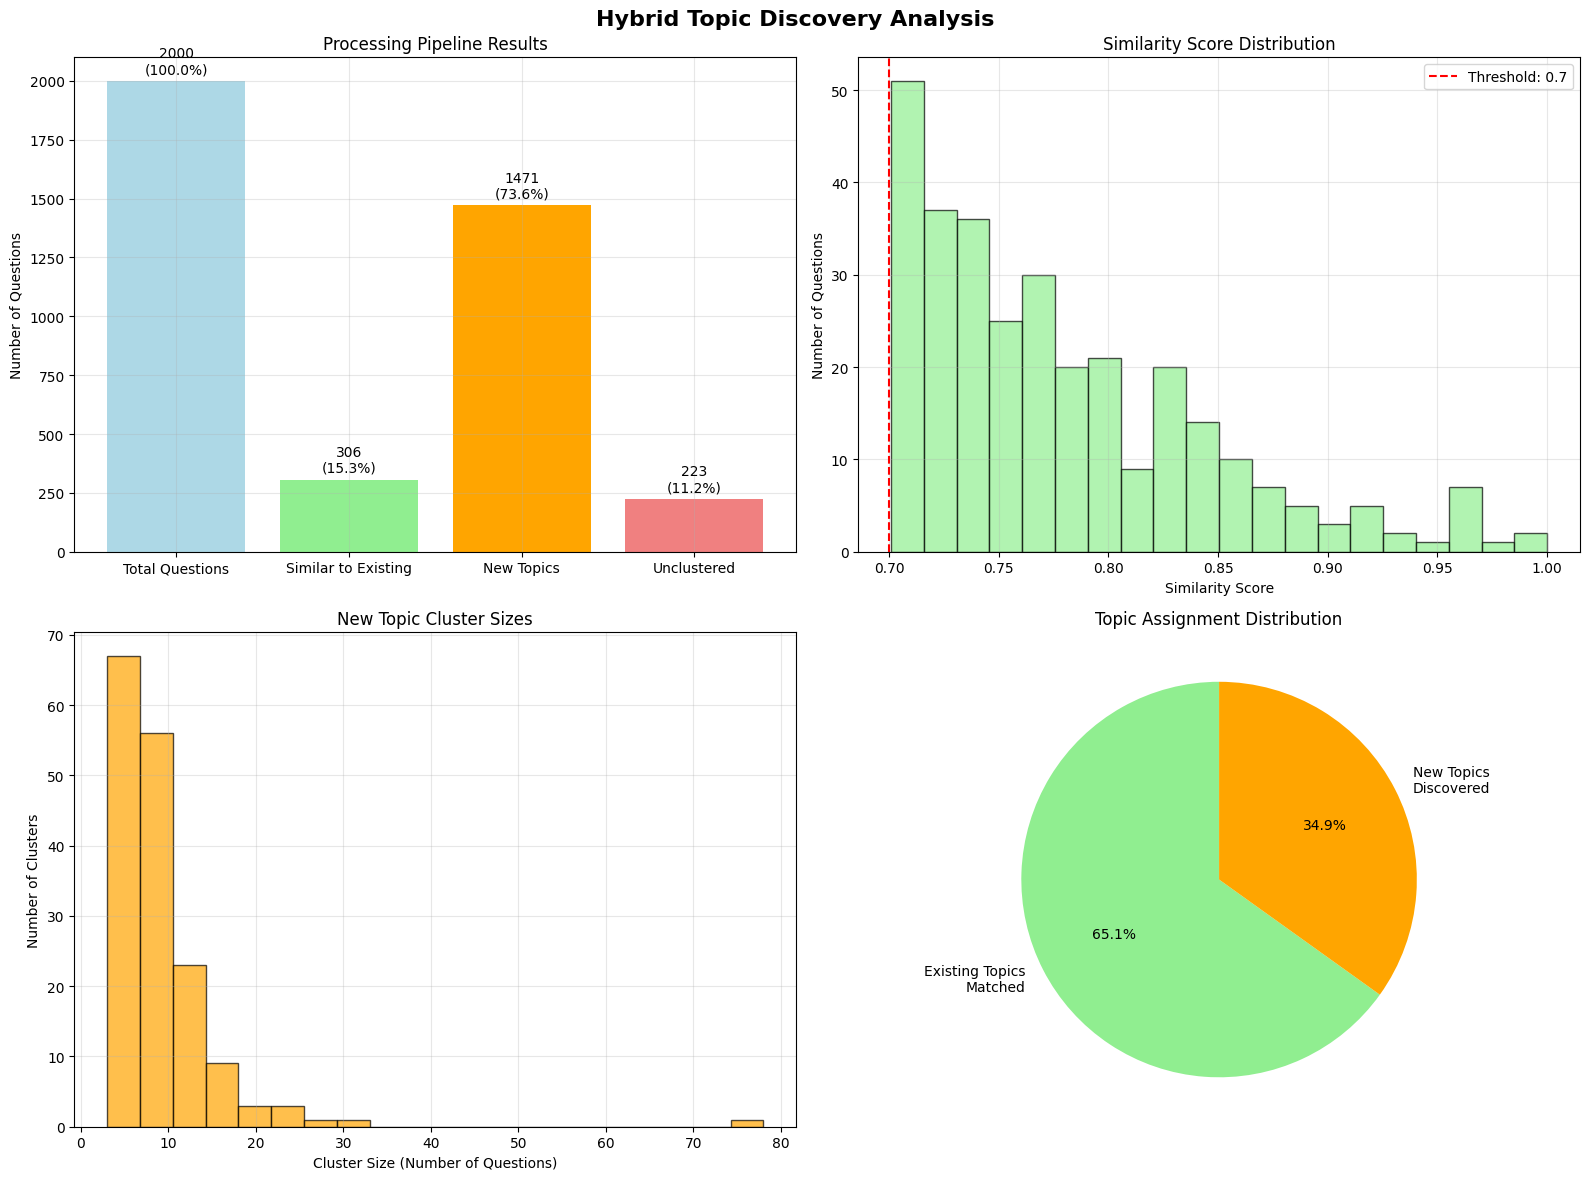


📊 DETAILED ANALYSIS:

🎯 SIMILARITY ANALYSIS:
   Questions matching existing topics: 306
   Average similarity score: 0.779
   Similarity range: 0.701 - 1.000
   Most frequently matched topics:
     - Ecclesiastical Endorsements: 36 questions
     - Continuing Student Registration: 31 questions
     - Academic Calendar: 27 questions
     - Returning Student: 24 questions
     - Tuition & Payments: 20 questions

🆕 CLUSTERING ANALYSIS:
   New topics discovered: 164
   Questions in new topics: 1471
   Average cluster size: 9.0 questions
   Largest cluster: 78 questions
   Smallest cluster: 3 questions

⚡ PERFORMANCE METRICS:
   Processing efficiency: 88.8%
   Similarity threshold effectiveness: 15.3%


In [ ]:
# ====================================================================
# ANALYSIS AND VISUALIZATION
# ====================================================================

def create_analysis_visualizations():
    """Create comprehensive analysis visualizations"""

    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Hybrid Topic Discovery Analysis', fontsize=16, fontweight='bold')

    # 1. Processing Pipeline Results
    pipeline_labels = ['Total Questions', 'Similar to Existing', 'New Topics', 'Unclustered']

    total_count = len(eval_questions_df)
    similar_count = len(similar_questions_df)
    new_topics_count = len(clustered_questions_df) if clustered_questions_df is not None else 0
    unclustered_count = total_count - similar_count - new_topics_count

    pipeline_counts = [total_count, similar_count, new_topics_count, unclustered_count]
    colors = ['lightblue', 'lightgreen', 'orange', 'lightcoral']

    bars = axes[0,0].bar(pipeline_labels, pipeline_counts, color=colors)
    axes[0,0].set_title('Processing Pipeline Results')
    axes[0,0].set_ylabel('Number of Questions')

    # Add percentage labels on bars
    for bar, count in zip(bars, pipeline_counts):
        height = bar.get_height()
        if height > 0:
            percentage = (count / total_count) * 100
            axes[0,0].text(bar.get_x() + bar.get_width()/2., height + total_count*0.01,
                          f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')

    axes[0,0].grid(True, alpha=0.3)

    # 2. Similarity Score Distribution
    if len(similar_questions_df) > 0:
        axes[0,1].hist(similar_questions_df['similarity_score'], bins=20, alpha=0.7,
                      color='lightgreen', edgecolor='black')
        axes[0,1].axvline(SIMILARITY_THRESHOLD, color='red', linestyle='--',
                         label=f'Threshold: {SIMILARITY_THRESHOLD}')
        axes[0,1].set_xlabel('Similarity Score')
        axes[0,1].set_ylabel('Number of Questions')
        axes[0,1].set_title('Similarity Score Distribution')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
    else:
        axes[0,1].text(0.5, 0.5, 'No similar questions found',
                      ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('Similarity Score Distribution')

    # 3. Cluster Size Distribution
    if clustered_questions_df is not None and len(clustered_questions_df) > 0:
        cluster_sizes = clustered_questions_df['cluster_id'].value_counts().values
        axes[1,0].hist(cluster_sizes, bins=min(20, len(cluster_sizes)), alpha=0.7,
                      color='orange', edgecolor='black')
        axes[1,0].set_xlabel('Cluster Size (Number of Questions)')
        axes[1,0].set_ylabel('Number of Clusters')
        axes[1,0].set_title('New Topic Cluster Sizes')
        axes[1,0].grid(True, alpha=0.3)
    else:
        axes[1,0].text(0.5, 0.5, 'No clusters found',
                      ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('New Topic Cluster Sizes')

    # 4. Processing Efficiency
    efficiency_labels = ['Existing Topics\nMatched', 'New Topics\nDiscovered']
    efficiency_values = [
        len(similar_questions_df) if len(similar_questions_df) > 0 else 0,
        len(topic_names) if len(topic_names) > 0 else 0
    ]

    if sum(efficiency_values) > 0:
        axes[1,1].pie(efficiency_values, labels=efficiency_labels, autopct='%1.1f%%',
                     colors=['lightgreen', 'orange'], startangle=90)
        axes[1,1].set_title('Topic Assignment Distribution')
    else:
        axes[1,1].text(0.5, 0.5, 'No topics assigned',
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Topic Assignment Distribution')

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print(f"\n📊 DETAILED ANALYSIS:")
    print(f"="*60)

    print(f"\n🎯 SIMILARITY ANALYSIS:")
    if len(similar_questions_df) > 0:
        print(f"   Questions matching existing topics: {len(similar_questions_df)}")
        print(f"   Average similarity score: {similar_questions_df['similarity_score'].mean():.3f}")
        print(f"   Similarity range: {similar_questions_df['similarity_score'].min():.3f} - {similar_questions_df['similarity_score'].max():.3f}")

        # Top matched topics
        top_topics = similar_questions_df['matched_topic'].value_counts().head(5)
        print(f"   Most frequently matched topics:")
        for topic, count in top_topics.items():
            print(f"     - {topic}: {count} questions")
    else:
        print(f"   No questions matched existing topics (threshold: {SIMILARITY_THRESHOLD})")

    print(f"\n🆕 CLUSTERING ANALYSIS:")
    if clustered_questions_df is not None and len(clustered_questions_df) > 0:
        print(f"   New topics discovered: {len(topic_names)}")
        print(f"   Questions in new topics: {len(clustered_questions_df)}")
        cluster_sizes = clustered_questions_df['cluster_id'].value_counts()
        print(f"   Average cluster size: {cluster_sizes.mean():.1f} questions")
        print(f"   Largest cluster: {cluster_sizes.max()} questions")
        print(f"   Smallest cluster: {cluster_sizes.min()} questions")
    else:
        print(f"   No new topics discovered through clustering")

    print(f"\n⚡ PERFORMANCE METRICS:")
    print(f"   Processing efficiency: {((len(similar_questions_df) + (len(clustered_questions_df) or 0)) / len(eval_questions_df) * 100):.1f}%")
    print(f"   Similarity threshold effectiveness: {(len(similar_questions_df) / len(eval_questions_df) * 100):.1f}%")

# Create analysis visualizations
create_analysis_visualizations()

## Configuration Summary & Next Steps

In [ ]:
# ====================================================================
# CONFIGURATION SUMMARY & NEXT STEPS
# ====================================================================

def print_configuration_summary():
    """Print a comprehensive summary of the configuration and results"""

    print(f"\n🔧 CONFIGURATION SUMMARY:")
    print(f"="*60)
    print(f"Processing Mode: {EVAL_MODE.upper()}")
    print(f"Sample Size: {SAMPLE_SIZE if EVAL_MODE == 'sample' else 'ALL'}")
    print(f"Similarity Threshold: {SIMILARITY_THRESHOLD}")
    print(f"Representative Question Method: {REPRESENTATIVE_QUESTION_METHOD}")
    print(f"Embedding Model: {EMBEDDING_MODEL}")
    print(f"GPT Model: {GPT_MODEL}")
    print(f"Random Seed: {RANDOM_SEED}")
    print(f"Caching: {'ENABLED' if CACHE_EMBEDDINGS else 'DISABLED'}")

    print(f"\n📊 PROCESSING RESULTS:")
    print(f"="*60)
    print(f"Total Questions Processed: {len(eval_questions_df)}")
    print(f"Similar to Existing Topics: {len(similar_questions_df)} ({len(similar_questions_df)/len(eval_questions_df)*100:.1f}%)")

    if clustered_questions_df is not None:
        print(f"New Topics Discovered: {len(topic_names)} topics covering {len(clustered_questions_df)} questions")
    else:
        print(f"New Topics Discovered: 0 (no clustering performed)")

    print(f"\n📁 OUTPUT FILES:")
    print(f"="*60)
    print(f"1. {output_files[0]}")
    print(f"   - Questions matching existing topics (≥{SIMILARITY_THRESHOLD} similarity)")
    print(f"   - Format: question, existing_topic, existing_subtopic, similarity_score")
    print(f"   - Count: {len(similar_questions_df)} questions")

    print(f"\n2. {output_files[1]}")
    print(f"   - New topics for Elder Edwards' review")
    print(f"   - Format: topic_name, representative_question, question_count")
    print(f"   - Count: {len(topic_names)} new topics")

    print(f"\n3. {output_files[2]}")
    print(f"   - Pathway questions review (all questions with topic assignments)")
    print(f"   - Format: question, topic_name")
    print(f"   - Includes questions under 'Other' topic (unclustered questions)")
    print(f"   - Count: All processed questions")

    print(f"\n💡 RECOMMENDATIONS FOR ELDER EDWARDS:")
    print(f"="*60)

    if len(similar_questions_df) > 0:
        print(f"✅ Review similar_questions file:")
        print(f"   - {len(similar_questions_df)} questions matched existing topics")
        print(f"   - Consider if similarity scores are appropriate")
        print(f"   - Verify topic assignments make sense")

    if len(topic_names) > 0:
        print(f"\n✅ Review new_topics file:")
        print(f"   - {len(topic_names)} new topics discovered")
        print(f"   - Consider adding promising topics to topic-questions.csv")
        print(f"   - Review representative questions for clarity")

        # Show largest clusters for immediate attention
        if clustered_questions_df is not None:
            largest_clusters = clustered_questions_df['cluster_id'].value_counts().head(3)
            print(f"\n   Priority topics (largest clusters):")
            for cluster_id, size in largest_clusters.items():
                topic_name = topic_names.get(cluster_id, f"Cluster_{cluster_id}")
                print(f"     - \"{topic_name}\" ({size} questions)")

    if len(similar_questions_df) == 0 and len(topic_names) == 0:
        print(f"⚠️  No topics discovered:")
        print(f"   - Consider lowering similarity threshold (current: {SIMILARITY_THRESHOLD})")
        print(f"   - Check if existing topic-questions.csv covers the domain well")
        print(f"   - Verify new questions are in the expected domain")

    print(f"\n🔄 NEXT ITERATION SUGGESTIONS:")
    print(f"="*60)
    print(f"1. Adjust SIMILARITY_THRESHOLD based on results")
    print(f"2. Add approved new topics to topic-questions.csv")
    print(f"3. Re-run with EVAL_MODE='all' for full dataset")
    print(f"4. Fine-tune clustering parameters if needed")

# Print comprehensive summary
print_configuration_summary()

print(f"\n🎉 HYBRID TOPIC DISCOVERY COMPLETE!")
print(f"Ready for Elder Edwards' review and feedback.")


🔧 CONFIGURATION SUMMARY:
Processing Mode: SAMPLE
Sample Size: 2000
Similarity Threshold: 0.7
Representative Question Method: centroid
Embedding Model: text-embedding-3-small
GPT Model: gpt-5-nano
Random Seed: 42
Caching: ENABLED

📊 PROCESSING RESULTS:
Total Questions Processed: 2000
Similar to Existing Topics: 306 (15.3%)
New Topics Discovered: 164 topics covering 1471 questions

📁 OUTPUT FILES:
1. similar_questions_20250918_124017.csv
   - Questions matching existing topics (≥0.7 similarity)
   - Format: question, existing_topic, existing_subtopic, similarity_score
   - Count: 306 questions

2. new_topics_20250918_124017.csv
   - New topics for Elder Edwards' review
   - Format: topic_name, representative_question, question_count
   - Count: 164 new topics

3. pathway_questions_review_20250918_124017.csv
   - Pathway questions review (all questions with topic assignments)
   - Format: question, topic_name
   - Includes questions under 'Other' topic (unclustered questions)
   - Count: